# Executive Summary

Implementing 2 content based recommender engines and comparing the results and methods of both approaches.

# Introduction

Content-based filtering: recommendation based on item(restaurant) or user attribute. 

Uses item features to recommend other items similar to what the user likes, based on their previous actions.

2 approaches are implemented in this file

1. Using only item attributes
2. Using both user profile and item attributes

# Data Load

In [1]:
#Import Statements
import pandas as pd
import numpy as np
import ast

#To Ignore Warnings in Output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the data
business = pd.read_csv('../data/output_csv/business_PA_Philly_clean.csv')
review = pd.read_csv('../data/output_csv/review_PA_Philly_clean.csv')

In [3]:
business.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count,categories,...,Seafood Markets,Wraps,Shaved Ice,Cupcakes,Greek,Flowers & Gifts,Home & Garden,French,Candy Stores,Chocolatiers & Shops
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,19107,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,19106,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,19147,39.943223,-75.162568,4.5,205,"Korean, Restaurants",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,19123,39.962582,-75.135657,3.5,65,"Eatertainment, Arts & Entertainment, Brewpubs,...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,19104,39.954573,-75.194894,3.0,56,"Restaurants, Automotive, Delis, Gas Stations, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
review.head()

,review_id,user_id,business_id,stars,year
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,2015
1,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,2013
2,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,2014
3,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,2018
4,YcLXh-3UC9y6YFAI9xxzPQ,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4,2015


# Data Clean

In [5]:
#Not using the columns with values other than 1 and 0
business = business.drop(columns = ['BYOBCorkage','NoiseLevel','RestaurantsAttire','RestaurantsPriceRange2','WiFi','AgesAllowed'])

In [6]:
#List of columns that represents categories and attributes
X = business.columns[11:]

In [7]:
#Converting these boolean values to int and getting the unique values of the columns
for i in range(len(X)):
    column_name = X[i]
    print(column_name)
    print("---------------")
    business[column_name] = business[column_name].astype(int)
    print(business[column_name].unique())
    print("***************")


AcceptsInsurance
---------------
[0 1]
***************
Alcohol
---------------
[0 1]
***************
Ambience
---------------
[0 1]
***************
BYOB
---------------
[0 1]
***************
BestNights
---------------
[0 1]
***************
BikeParking
---------------
[1 0]
***************
BusinessAcceptsBitcoin
---------------
[0 1]
***************
BusinessAcceptsCreditCards
---------------
[0 1]
***************
BusinessParking
---------------
[1 0]
***************
ByAppointmentOnly
---------------
[0 1]
***************
Caters
---------------
[1 0]
***************
CoatCheck
---------------
[0 1]
***************
Corkage
---------------
[0 1]
***************
DietaryRestrictions
---------------
[0 1]
***************
DogsAllowed
---------------
[0 1]
***************
DriveThr
---------------
[0 1]
***************
GoodForDancing
---------------
[0 1]
***************
GoodForKids
---------------
[0 1]
***************
GoodForMeal
---------------
[0 1]
***************
HappyHour
---------------
[

In [8]:
business_names = business.loc[:,['business_id', 'name']]

In [9]:
#Entering a user id input
UID = '--2tyArRmSoyKx5r-FVG0A'

In [10]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype


user_u = list(sorted(review.user_id.unique()))
business_u = list(sorted(review.business_id.unique()))

cat_type_user = CategoricalDtype(categories=user_u, ordered=True)
cat_type_business = CategoricalDtype(categories=business_u, ordered=True)

row = review.user_id.astype(cat_type_user).cat.codes
col = review.business_id.astype(cat_type_business).cat.codes

data = review['stars'].tolist()

sparse_matrix = csr_matrix((data, (row, col)), shape=(len(user_u), len(business_u)))


In [11]:
sparse_matrix

<184805x4372 sparse matrix of type '<class 'numpy.intc'>'
	with 530993 stored elements in Compressed Sparse Row format>

In [12]:

ratings = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,index=user_u, columns=business_u)

In [13]:
#row = user_id
#column = business_id
#df is visited information matrix, along with rating given to each restaurant
ratings.head()

,-0TffRSXXIlBYVbb5AwfTg,-1B9pP_CrRBJYPICE5WbRA,-3ArWZfDjfab8qVHf3WVtg,-3m_nXlyvdKAVNNmVirpGQ,-5Rah4ZvWsDu4oilUZxhtw,-63ytt5vkWof-M9NDGTkng,-6MEKOmFu6jckT3pruSxHg,-ATiAtTikuGuqvaW2O6tNA,-AanHawaDlzWHQjrqRRWig,-Bhoyo7LL97tgt9Hze0Saw,...,zuEdIZKAYBDfPjyFg6B34Q,zuKnCtZQKZqnvEaKVnwVVQ,zucC7rHpXPYBu7aEqj0NUw,zujdPV3HT-Y-CKE1GgkMHQ,zvvl3c1FO3O3BZdhusficA,zwTmOj4B_OVPMTMYijQiKg,zwd4dyQ5ovnjVojWfAuhMw,zxRmQ_FWVowh8rlzLCSURQ,zxY4DgtXsVHihSUpsmwamg,zz3E7kmJI2r2JseE6LAnrw
--2tyArRmSoyKx5r-FVG0A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--2vR0DIsmQ6WfcSzKWigw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--4AjktZiHowEIBCMd4CZA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--4_p6Z3tKadJcr9Non_Vw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--6GckBYtTa4hj8pT09oAg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Content Based Filtering

### Approach 1 - Item Attributes Only

##### Step 1: For each item (restaurant), obtain the attributes

In [14]:
#Business categories and attributes
business_categories = business.iloc[:,11:]

In [15]:
#Adding the business id column
business_categories['business_id'] = business['business_id']

In [16]:
#Resetting the index in business categories to business_id
business_categories.index = business_categories['business_id']

In [17]:
#Dropping the extra column business_id as it's alredy in index
business_categories = business_categories.drop(columns = ['business_id'])

In [18]:
#Business_Categories dataframe
business_categories

,AcceptsInsurance,Alcohol,Ambience,BYOB,BestNights,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking,ByAppointmentOnly,...,Seafood Markets,Wraps,Shaved Ice,Cupcakes,Greek,Flowers & Gifts,Home & Garden,French,Candy Stores,Chocolatiers & Shops
business_id,,,,,,,,,,,,,,,,,,,,,
MTSW4McQd7CbVtyjqoe9mw,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
MUTTqe8uqyMdBl186RmNeA,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ROeacJQwBeh05Rqg7F6TCg,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
aPNXGTDkf-4bjhyMBQxqpQ,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ppFCk9aQkM338Rgwpl2F5A,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K1SsvIPfFcHniNSPc3IG7g,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
mzTTdvQGkUHZ8ii7OnZC5w,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
OfRbGvHn-nAnQMqNxiIpcA,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Step 2: Calculate similarity between items (restaurants)

Similarity metric used: Cosine Similarity - The larger the value, the more similar.

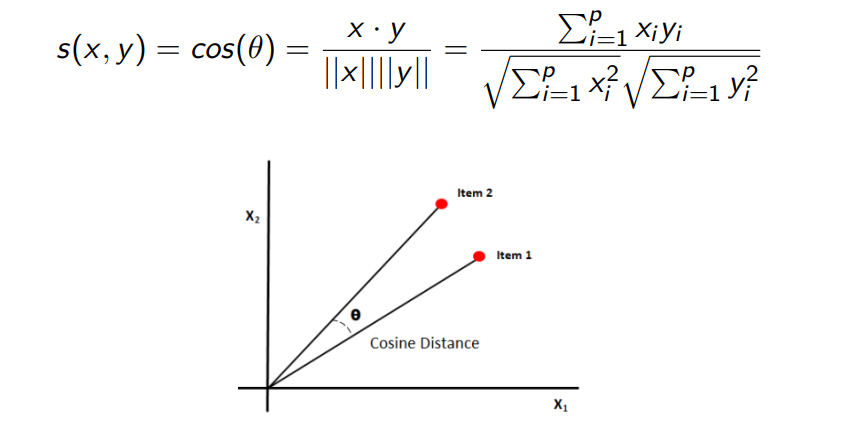

In [19]:
# Calculating the cosine similarity of the restaurants (based on categories)
from sklearn.metrics.pairwise import cosine_similarity
business_categories_sim = cosine_similarity(business_categories)
business_categories_sim = pd.DataFrame(business_categories_sim,
                                       index = business_categories.index,
                                       columns = business_categories.index)

##### Step 3: Recommends user restaurants that is most similar to user’s previously visited restaurants

In [20]:
# The following function will take in the business id, then returns the top n recommendations.
def print_recommendations(original_item, top_n):
    """
    inputs: original_item <int>: is the id of the item we want to make 
                                 recommendation for
            top_n <int>: number of items we want to recommend for the 
                         original item
    """
    idx = original_item
    print("Your original item is", business_names[business_names['business_id'] == str(idx)]['name'].values)
    recommends = business_categories_sim.loc[str(idx)].sort_values(ascending = False)[1:].index
    cba1 = []
    for i in range(top_n):
        rec_restaurant = recommends[i]
        cba1.append(business_names[business_names['business_id'] == rec_restaurant]['name'].values[0])
        print("my number ", i+1, " recommendation is ", 
              business_names[business_names['business_id'] == rec_restaurant]['name'].values)
    return cba1

In [21]:
#Get personalised recommendations for each user with their favorite restaurant
recommendations_cba1 = print_recommendations(ratings.loc[UID,:].idxmax(), 10)


Your original item is ['Yakitori Boy']
my number  1  recommendation is  ['Ramen Bar']
my number  2  recommendation is  ['Aki Nom Nom Sushi & Ramen']
my number  3  recommendation is  ['MUTA Korean BBQ & Karaoke']
my number  4  recommendation is  ['Ramen Bar']
my number  5  recommendation is  ["P. J. Clarke's"]
my number  6  recommendation is  ['Heritage']
my number  7  recommendation is  ['Gojjo Bar & Restaurant']
my number  8  recommendation is  ['El Poquito']
my number  9  recommendation is  ['Devon Seafood Grill']
my number  10  recommendation is  ['Queen Sheba']


### Approach 2 - User Profile and Item Attributes

We have user profile, can leverage that information as well. This method is based on user’s taste and item content

In [22]:
def print_recommendations2(uid, top_n):
    """
    inputs: uid <int>: is the id of the user we want to make 
                                 recommendation for
            top_n <int>: number of items we want to recommend for the 
                         original item
    """
    # Extract the user rating
    user_rating = ratings.loc[ratings.index == uid,:]
    user_rating = user_rating.fillna(0)

    # Calculate the weighted attributes
    weighted_attribute = pd.DataFrame(columns = business_categories.columns)
    watched = np.where(user_rating.iloc[0,:] != 0)[0] # Which movies did the user rated
    restaurant_id = user_rating.columns[watched] # The IDs of the rated movies
    for i in range(len(watched)):
        ID = restaurant_id[i]
        scores = np.array(user_rating.iloc[:,watched[i]]) * np.array(business_categories.loc[str(ID),:])
        scores = pd.DataFrame(scores).T
        scores.columns = business_categories.columns
        weighted_attribute = weighted_attribute.append(scores)

    # Obtain new rating
    scaled_attribute = np.sum(weighted_attribute, axis = 0)/ np.sum(np.sum(weighted_attribute))
    restaurant_drop = business_categories.drop(index = map(str, restaurant_id))
    weighted_rating = restaurant_drop.mul(scaled_attribute, axis=1)
    new_ratings = np.sum(weighted_rating, axis = 1)
    nr = new_ratings.sort_values(ascending = False)
    
    # Print the movies the user has watched
    restaurants_visited = []
    for i in range(len(restaurant_id)):
        restaurants_visited.append(business_names[business_names['business_id'] == str(restaurant_id[i])]['name'].values)

    flat_list = [item for sublist in restaurants_visited for item in sublist]
    print('The user has visited these restaurants: \n')
    print('; '.join(flat_list), '\n')
    cba2 = []
    # Recommendations
    for i in range(top_n):
        cba2.append(business_names[business_names['business_id'] == nr.index[i]]['name'].values[0])
        print("Recommendation", i, "is ", business_names[business_names['business_id'] == nr.index[i]]['name'].values)
    return cba2

In [23]:
recommendations_cba2 = print_recommendations2(UID,10)

The user has visited these restaurants: 

Finn McCool's Ale House; Yakitori Boy 

Recommendation 0 is  ['Aki Nom Nom Sushi & Ramen']
Recommendation 1 is  ['Yamitsuki Ramen']
Recommendation 2 is  ['Alamodak Restaurant and Hookah Lounge']
Recommendation 3 is  ["Jerry's Bar"]
Recommendation 4 is  ["P. J. Clarke's"]
Recommendation 5 is  ["Ruth's Chris Steak House"]
Recommendation 6 is  ['Cleavers']
Recommendation 7 is  ['Hard Rock Cafe']
Recommendation 8 is  ["Moriarty's Restaurant and Irish Pub"]
Recommendation 9 is  ["Chick's Philly"]


#### Comparison of the two approaches

In [24]:
comparison_df = pd.DataFrame({'Item Attributes Only':recommendations_cba1,
                              'User Profile + Item Attributes':recommendations_cba2})

In [25]:
comparison_df

,Item Attributes Only,User Profile + Item Attributes
0,Ramen Bar,Aki Nom Nom Sushi & Ramen
1,Aki Nom Nom Sushi & Ramen,Yamitsuki Ramen
2,MUTA Korean BBQ & Karaoke,Alamodak Restaurant and Hookah Lounge
3,Ramen Bar,Jerry's Bar
4,P. J. Clarke's,P. J. Clarke's
5,Heritage,Ruth's Chris Steak House
6,Gojjo Bar & Restaurant,Cleavers
7,El Poquito,Hard Rock Cafe
8,Devon Seafood Grill,Moriarty's Restaurant and Irish Pub
9,Queen Sheba,Chick's Philly
